In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import KeyedVectors

In [2]:
import pandas as pd
import numpy as np
import pickle
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annadosenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/annadosenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/annadosenko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [4]:
style.use('seaborn-poster')
style.use('ggplot')

Loading data

In [5]:
dataset = pd.read_csv("/Users/annadosenko/Study/IndustrialML/2Lab/Dataset_movies_final_clean.csv")
train_data = pd.read_csv("/Users/annadosenko/Study/IndustrialML/2Lab/train_data_clean.csv")
test_data = pd.read_csv("/Users/annadosenko/Study/IndustrialML/2Lab/test_data_clean.csv")
val_data = pd.read_csv("/Users/annadosenko/Study/IndustrialML/2Lab/val_data_clean.csv")

In [ ]:
dataset['genre_list'] = dataset['genre_list'].apply(lambda x: ast.literal_eval(x))
train_data['genre_list'] = train_data['genre_list'].apply(lambda x: ast.literal_eval(x))
test_data['genre_list'] = test_data['genre_list'].apply(lambda x: ast.literal_eval(x))
val_data['genre_list'] = val_data['genre_list'].apply(lambda x: ast.literal_eval(x))

In [6]:
train_data['description'] = train_data['description'].astype(str)
test_data['description'] = test_data['description'].astype(str)
val_data['description'] = val_data['description'].astype(str)

train_data['origin_title'] = train_data['origin_title'].astype(str)
test_data['origin_title'] = test_data['origin_title'].astype(str)
val_data['origin_title'] = val_data['origin_title'].astype(str)

dataset['description'] = dataset['description'].astype(str)
dataset['origin_title'] = dataset['origin_title'].astype(str)

#### Label generation

Using scikit-learn's Mutltilabel Binarizer to generate one-hot encoded vectors. There are a total of 23 classes and each label is associated with an array index.

In [12]:
mlb = MultiLabelBinarizer()
mlb.fit(dataset['genre_list'].tolist())
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'],
      dtype=object)

In [13]:
transformed_labels = mlb.fit_transform(dataset['genre_list'].tolist())
transformed_labels.shape

(146444, 23)

In [14]:
train_labels = mlb.transform(train_data['genre_list'].tolist())
train_labels.shape

(105439, 23)

In [15]:
test_labels = mlb.transform(test_data['genre_list'].tolist())
test_labels.shape

(29289, 23)

In [16]:
val_labels = mlb.transform(val_data['genre_list'].tolist())
val_labels.shape

(11716, 23)

In [17]:
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv2D, MaxPooling2D, concatenate, Conv1D, MaxPooling1D
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

Fitting the Keras Tokenizer on the entire dataset

In [18]:
MAX_NB_WORDS_DESCRIPTION = 50000
MAX_SEQUENCE_LENGTH_DESCRIPTION = dataset['description'].map(len).max()
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS_DESCRIPTION, lower=True)
tokenizer.fit_on_texts(dataset['description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Max len:', MAX_SEQUENCE_LENGTH_DESCRIPTION)

Found 122093 unique tokens.
Max len: 364


In [19]:
MAX_NB_WORDS_TITLES = 10000
MAX_SEQUENCE_LENGTH_TITLES = dataset['origin_title'].map(len).max()
EMBEDDING_DIM_TITLES = 150
tokenizer_titles = Tokenizer(num_words=MAX_NB_WORDS_TITLES, lower=True)
tokenizer_titles.fit_on_texts(dataset['origin_title'].values)
word_index_titles = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index_titles))
print('Max len:', MAX_SEQUENCE_LENGTH_TITLES)

Found 122093 unique tokens.
Max len: 150


In [20]:
X_text_train_description = tokenizer.texts_to_sequences(train_data['description'].values)
X_text_train_description = pad_sequences(X_text_train_description, maxlen=MAX_SEQUENCE_LENGTH_DESCRIPTION)
print('Shape of train tensor:', X_text_train_description.shape)

Shape of train tensor: (105439, 364)


In [21]:
X_text_train_titles = tokenizer_titles.texts_to_sequences(train_data['origin_title'].values)
X_text_train_titles = pad_sequences(X_text_train_titles, maxlen=MAX_SEQUENCE_LENGTH_TITLES)
print('Shape of train tensor:', X_text_train_titles.shape)

Shape of train tensor: (105439, 150)


In [22]:

X_text_test_description = tokenizer.texts_to_sequences(test_data['description'].values)
X_text_test_description = pad_sequences(X_text_test_description, maxlen=MAX_SEQUENCE_LENGTH_DESCRIPTION)
print('Shape of train tensor:', X_text_test_description.shape)

Shape of train tensor: (29289, 364)


In [23]:
X_text_test_titles = tokenizer_titles.texts_to_sequences(test_data['origin_title'].values)
X_text_test_titles = pad_sequences(X_text_test_titles, maxlen=MAX_SEQUENCE_LENGTH_TITLES)
print('Shape of train tensor:', X_text_test_titles.shape)

Shape of train tensor: (29289, 150)


In [24]:
X_text_val_description = tokenizer.texts_to_sequences(val_data['description'].values)
X_text_val_description = pad_sequences(X_text_val_description, maxlen=MAX_SEQUENCE_LENGTH_DESCRIPTION)
print('Shape of train tensor:', X_text_val_description.shape)

Shape of train tensor: (11716, 364)


In [25]:
X_text_val_titles = tokenizer_titles.texts_to_sequences(val_data['origin_title'].values)
X_text_val_titles = pad_sequences(X_text_val_titles, maxlen=MAX_SEQUENCE_LENGTH_TITLES)
print('Shape of train tensor:', X_text_val_titles.shape)

Shape of train tensor: (11716, 150)


In [29]:
def get_embedding_matrix(typeToLoad):
    word2vecDict = KeyedVectors.load_word2vec_format("/Users/annadosenko/Study/IndustrialML/2Lab/GoogleNews-vectors-negative300.bin", binary=True)
    embed_size = 300
    embeddings_index = dict()
    for word in word2vecDict.key_to_index:
      embeddings_index[word] = word2vecDict.word_vec(word)
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
    embedding_matrix = 1 * np.random.randn(len(word_index)+1, embed_size)

    embeddedCount = 0
    for word, i in word_index.items():
        i-=1
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            embeddedCount+=1
    print("total embedded:", embeddedCount, "common words")
        
    del(embeddings_index)
        
    return embedding_matrix

In [30]:
word2vec_embedding_matrix = get_embedding_matrix()

/var/folders/bt/wbbq7g4d2blfvwqjgb8qk8vw0000gn/T/ipykernel_1526/10686291.py:26: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embeddings_index[word] = word2vecDict.word_vec(word)


Loaded 3000000 word vectors.
total embedded: 45245 common words


In [31]:
def get_embedding_matrix_titles(typeToLoad):
    word2vecDict = KeyedVectors.load_word2vec_format("/Users/annadosenko/Study/IndustrialML/2Lab/GoogleNews-vectors-negative300.bin", binary=True)
    embed_size = 300

    embeddings_index = dict()
    #for word in word2vecDict.wv.vocab:
    for word in word2vecDict.key_to_index:
        embeddings_index[word] = word2vecDict.word_vec(word)
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
    embedding_matrix = 1 * np.random.randn(len(word_index_titles)+1, embed_size)

    embeddedCount = 0
    for word, i in word_index_titles.items():
        i-=1
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            embeddedCount+=1
    print("total embedded:", embeddedCount, "common words")
        
    del(embeddings_index)
        
    return embedding_matrix

In [32]:
word2vec_embedding_matrix_titles = get_embedding_matrix_titles()

/var/folders/bt/wbbq7g4d2blfvwqjgb8qk8vw0000gn/T/ipykernel_1526/2263748107.py:26: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embeddings_index[word] = word2vecDict.word_vec(word)


Loaded 3000000 word vectors.
total embedded: 45245 common words


In [33]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [34]:
device = torch.device('cpu')
print(device)

cpu


In [35]:
# del model
torch.cuda.empty_cache()

In [36]:
X_img_val = np.reshape(X_img_val, (X_img_val.shape[0], 3, 75, 115))
X_img_val.shape

(11716, 3, 75, 115)

In [37]:
X_img_test = np.reshape(X_img_test, (X_img_test.shape[0], 3, 75, 115))

In [38]:
X_img_train = np.reshape(X_img_train, (X_img_train.shape[0], 3, 75, 115))

Creating data loaders for the text and image inputs for the train, validation and test sets.

In [39]:
text_train_data_description = TensorDataset(torch.from_numpy(X_text_train_description), torch.from_numpy(train_labels))
img_train_data = TensorDataset(torch.from_numpy(X_img_train), torch.from_numpy(train_labels))
text_train_data_titles = TensorDataset(torch.from_numpy(X_text_train_titles), torch.from_numpy(train_labels))

text_val_data_description = TensorDataset(torch.from_numpy(X_text_val_description), torch.from_numpy(val_labels))
img_val_data = TensorDataset(torch.from_numpy(X_img_val), torch.from_numpy(val_labels))
text_val_data_titles = TensorDataset(torch.from_numpy(X_text_val_titles), torch.from_numpy(val_labels))

text_test_data_description = TensorDataset(torch.from_numpy(X_text_test_description), torch.from_numpy(test_labels))
img_test_data = TensorDataset(torch.from_numpy(X_img_test), torch.from_numpy(test_labels))
text_test_data_titles = TensorDataset(torch.from_numpy(X_text_test_titles), torch.from_numpy(test_labels))

batch_size = 64

text_train_loader_description = DataLoader(text_train_data_description, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)
text_train_loader_titles = DataLoader(text_train_data_titles, batch_size=batch_size)

text_val_loader_description = DataLoader(text_val_data_description, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)
text_val_loader_titles = DataLoader(text_val_data_titles, batch_size=batch_size)

text_test_loader_description = DataLoader(text_test_data_description, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)
text_test_loader_titles = DataLoader(text_test_data_titles, batch_size=batch_size)

print(len(text_train_loader_description), len(img_train_loader), len(text_train_loader_titles))
print(len(text_val_loader_description), len(img_val_loader), len(text_val_loader_titles))
print(len(text_test_loader_description), len(img_test_loader), len(text_test_loader_titles))

1648 1648 1648
184 184 184
458 458 458


The model consisting of a CNN and LSTM with their outputs being fed into a set of fully connected layers.

In [40]:
class CNN_LSTM(nn.Module):
  def __init__(self, vocab_size, vocab_size_titles, weights_matrix, weights_matrix_titles, n_hidden, n_layers, n_out):
    super(CNN_LSTM, self).__init__()

    # LSTM for the text overview
    self.vocab_size, self.vocab_size_titles, self.n_hidden, self.n_out, self.n_layers = vocab_size, vocab_size_titles, n_hidden, n_out, n_layers
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    num_embeddings_titles, embedding_dim_titles = weights_matrix_titles.shape[0], weights_matrix_titles.shape[1]
    self.emb = nn.Embedding(num_embeddings, embedding_dim)
    self.emb_titles = nn.Embedding(num_embeddings_titles, embedding_dim_titles)
    self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
    self.emb_titles.weight.data.copy_(torch.from_numpy(weights_matrix_titles))
    self.emb.weight.requires_grad = True
    self.emb_titles.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.lstm_titles = nn.LSTM(embedding_dim_titles, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(0.1)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)
    # self.sigmoid = nn.Sigmoid()

    # CNN for the posters
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.max_pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.max_pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.max_pool3 = nn.MaxPool2d(2)
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.max_pool4 = nn.MaxPool2d(2)
    self.cnn_dropout = nn.Dropout(0.1)
    self.cnn_fc = nn.Linear(5*2*128, 512)

    # Concat layer for the combined feature space
    #self.combined_fc1 = nn.Linear(640, 256)
    self.combined_fc1 = nn.Linear(768, 256)
    self.combined_fc2 = nn.Linear(256, 64)
    self.output_fc = nn.Linear(64, n_out)


  def forward(self, lstm_inp, lstm_inp_titles, cnn_inp):
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    embeds_titles = self.emb(lstm_inp_titles)
    lstm_out_titles, hidden_titles = self.lstm(embeds_titles, hidden)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))
    lstm_out_titles = self.dropout(lstm_out_titles[:, -1])
    lstm_out_titles = F.relu(self.lstm_fc(lstm_out_titles))

    x = F.relu(self.conv1(cnn_inp))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool3(x)
    x = F.relu(self.conv4(x))
    x = self.max_pool4(x)
    x = x.view(-1, 5*2*128)
    x = self.cnn_dropout(x)
    cnn_out = F.relu(self.cnn_fc(x))

    combined_inp = torch.cat((cnn_out, lstm_out, lstm_out_titles), 1)
    x_comb = F.relu(self.combined_fc1(combined_inp))
    x_comb = F.relu(self.combined_fc2(x_comb))
    out = torch.sigmoid(self.output_fc(x_comb))

    return out

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
    return hidden

Defining the hyperparameters of the model along with defining the optimizer and loss function. Similar to Keras, the binary cross entropy loss is used. In order to fine tune the model, the embedding layer which has teh word2vec embedding is also trainable. This was done as a significant amount of words were not present in the word2vec vocab.

In [41]:
vocab_size = len(word_index)+1
output_size = train_labels.shape[1]
vocab_size_titles = len(word_index_titles)+1
embedding_dim = 300
hidden_dim = 64
n_layers = 2
print(output_size)

model = CNN_LSTM(vocab_size, vocab_size_titles, word2vec_embedding_matrix, word2vec_embedding_matrix_titles,
                 hidden_dim, n_layers, output_size)
model.to(device)
print(model)

lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

23
CNN_LSTM(
  (emb): Embedding(122094, 300)
  (emb_titles): Embedding(122094, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (lstm_titles): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc)

Training and validation of the model. A batchsize of 64 is used to prevent an out of memory error.

In [43]:
from tqdm import tqdm
epochs = 10
clip = 5

train_loss_arr, validation_loss_arr = [], []
train_accuracy_arr, validation_accuracy_arr = [], []

model.train()
for i in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    print(f"epoch {i}")
    
    for lstm, lstm_titles, cnn in tqdm(zip(text_train_loader_description,text_train_loader_titles, img_train_loader)):
        lstm_inp, lstm_labels = lstm
        lstm_inp_titles, lstm_labels_titles = lstm_titles
        cnn_inp, cnn_labels = cnn
        lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
        lstm_inp_titles, lstm_labels_titles = lstm_inp_titles.to(device), lstm_labels_titles.to(device)
        cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
        model.zero_grad()
        output = model(lstm_inp, lstm_inp_titles, cnn_inp)
        loss = criterion(output.squeeze(), lstm_labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
        with torch.no_grad():
          acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
          acc = (1. - acc.sum() / acc.size()[0])
          total_acc_train += acc
          total_loss_train += loss.item()
  
    train_acc = total_acc_train/len(text_train_loader_description)
    train_loss = total_loss_train/len(text_train_loader_description)
    train_accuracy_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    model.eval()
    total_acc_val = 0
    total_loss_val = 0
    with torch.no_grad():
        for lstm, lstm_titles, cnn in tqdm(zip(text_val_loader_description, text_val_loader_titles, img_val_loader)):
            lstm_inp, lstm_labels = lstm
            lstm_inp_titles, lstm_labels_titles = lstm_titles
            cnn_inp, cnn_labels = cnn
            lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
            lstm_inp_titles, lstm_labels_titles = lstm_inp.to(device), lstm_labels.to(device)
            cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
            model.zero_grad()
            output = model(lstm_inp, lstm_inp_titles, cnn_inp)
            val_loss = criterion(output.squeeze(), lstm_labels.float())
            acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_val += acc
            total_loss_val += val_loss.item()
        print("Saving model...") 
        torch.save(model.state_dict(), '/Users/annadosenko/Study/IndustrialML/2Lab/model_second_attempt/pytorch_word2vec_lstm_less_dropout.pt')

    val_acc = total_acc_val/len(text_val_loader_description)
    val_loss = total_loss_val/len(text_val_loader_description)
    validation_loss_arr.append(val_loss)
    validation_accuracy_arr.append(val_acc)
    print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    model.train()
    torch.cuda.empty_cache()

epoch 0


1648it [1:00:30,  2.20s/it]
184it [02:27,  1.25it/s]


Saving model...
Epoch 1: train_loss: 0.2380 train_acc: 0.8655 | val_loss: 0.2268 val_acc: 0.8774
epoch 1


1648it [1:15:25,  2.75s/it]
184it [01:54,  1.61it/s]


Saving model...
Epoch 2: train_loss: 0.2114 train_acc: 0.8791 | val_loss: 0.2088 val_acc: 0.8815
epoch 2


1648it [2:48:55,  6.15s/it]
184it [33:35, 10.96s/it]


Saving model...
Epoch 3: train_loss: 0.1957 train_acc: 0.8877 | val_loss: 0.2016 val_acc: 0.8929
epoch 3


1648it [2:02:51,  4.47s/it]
184it [02:00,  1.53it/s]


Saving model...
Epoch 4: train_loss: 0.1858 train_acc: 0.8931 | val_loss: 0.1967 val_acc: 0.8967
epoch 4


1648it [2:02:34,  4.46s/it]
184it [02:01,  1.52it/s]


Saving model...
Epoch 5: train_loss: 0.1774 train_acc: 0.8978 | val_loss: 0.1931 val_acc: 0.8985
epoch 5


1648it [2:01:05,  4.41s/it]
184it [02:37,  1.17it/s]


Saving model...
Epoch 6: train_loss: 0.1700 train_acc: 0.9020 | val_loss: 0.1942 val_acc: 0.8987
epoch 6


1648it [58:18,  2.12s/it]
184it [02:16,  1.35it/s]


Saving model...
Epoch 7: train_loss: 0.1633 train_acc: 0.9058 | val_loss: 0.1982 val_acc: 0.8998
epoch 7


1648it [55:32,  2.02s/it]
184it [02:08,  1.43it/s]


Saving model...
Epoch 8: train_loss: 0.1576 train_acc: 0.9090 | val_loss: 0.2011 val_acc: 0.9007
epoch 8


1648it [1:06:03,  2.40s/it]
184it [02:36,  1.18it/s]


Saving model...
Epoch 9: train_loss: 0.1527 train_acc: 0.9119 | val_loss: 0.2026 val_acc: 0.9009
epoch 9


1648it [2:04:56,  4.55s/it]
184it [02:07,  1.44it/s]


Saving model...
Epoch 10: train_loss: 0.1489 train_acc: 0.9141 | val_loss: 0.2030 val_acc: 0.8997


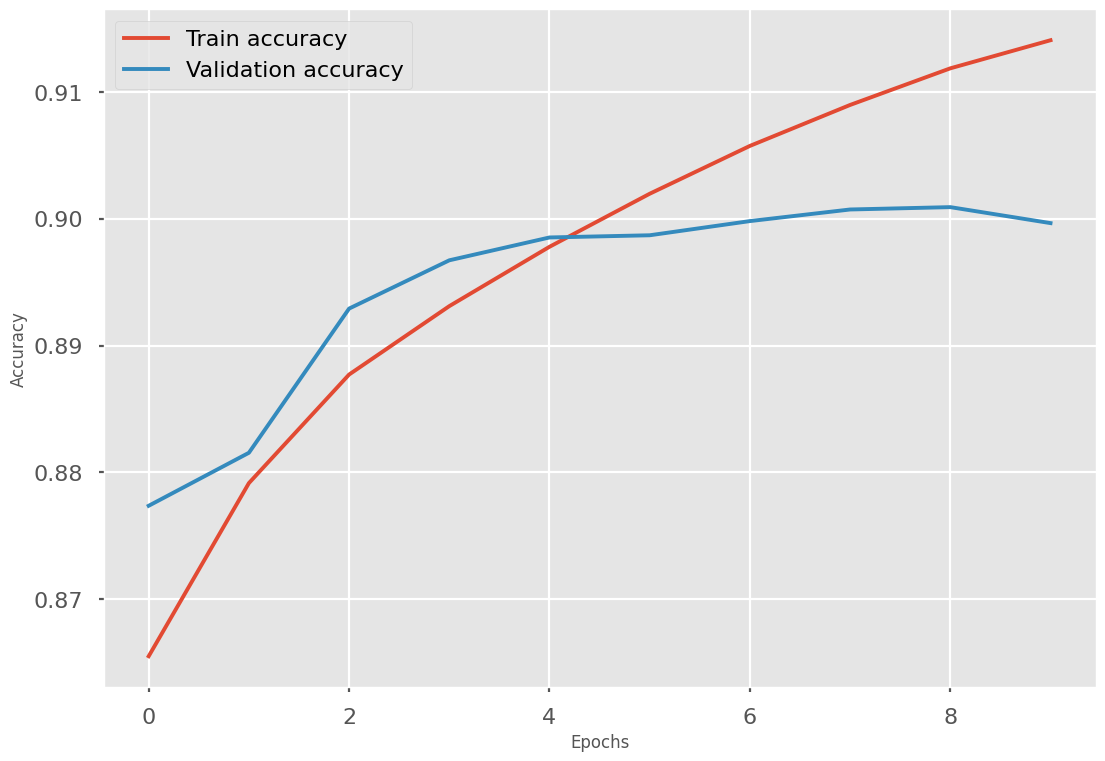

In [44]:
epochs_arr = np.arange(0, 10)
plt.plot(epochs_arr, train_accuracy_arr, label='Train accuracy')
plt.plot(epochs_arr, validation_accuracy_arr, label='Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.savefig('pytorch_implementation_accuracy.png')
plt.close()

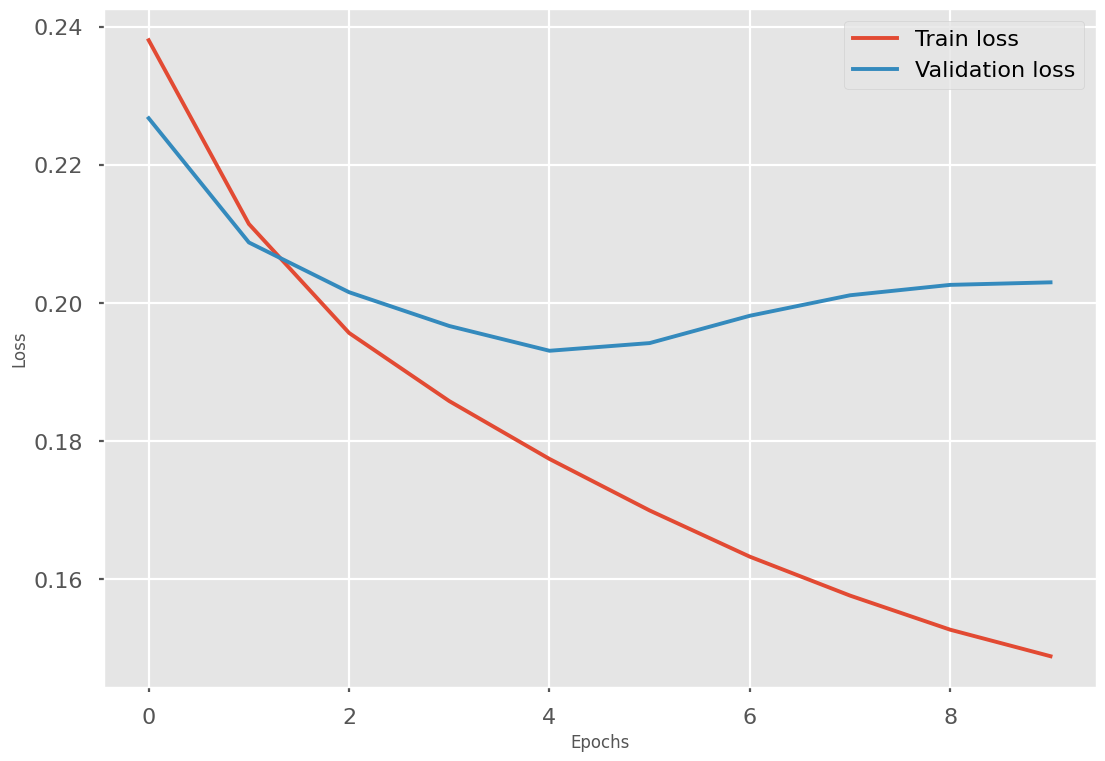

In [45]:
plt.plot(epochs_arr, train_loss_arr, label='Train loss')
plt.plot(epochs_arr, validation_loss_arr, label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.savefig('pytorch_implementation_loss.png')
plt.close()

### Testing the model

In [46]:
model.eval()
total_acc_test = 0
total_loss_test = 0
outputs = []
with torch.no_grad():
    for lstm, lstm_titles, cnn in tqdm(zip(text_test_loader_description, text_test_loader_titles, img_test_loader)):
        lstm_inp, lstm_labels = lstm
        lstm_inp_titles, lstm_labels_titles = lstm_titles
        cnn_inp, cnn_labels = cnn
        lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
        lstm_inp_titles, lstm_labels_titles = lstm_inp_titles.to(device), lstm_labels_titles.to(device)
        cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
        out = model(lstm_inp, lstm_inp_titles, cnn_inp)
        outputs += list(out.cpu().data.numpy())
        loss = criterion(out.squeeze(), lstm_labels.float())
        acc = torch.abs(out.squeeze() - lstm_labels.float()).view(-1)
        acc = (1. - acc.sum() / acc.size()[0])
        total_acc_test += acc
        total_loss_test += loss.item()

acc_test = total_acc_test/len(text_test_loader_description)
loss_test = total_loss_test/len(text_test_loader_description)
print(f'acc: {acc_test:.4f} loss: {loss_test:.4f}')

458it [05:07,  1.49it/s]

acc: 0.8992 loss: 0.1978


In [47]:
np_out = np.array(outputs)

In [48]:
y_pred = np.zeros(np_out.shape)
y_pred[np_out>0.5]=1
y_pred = np.array(y_pred)

In [51]:
print(f"Recall score: {recall_score(test_labels, y_pred, average='samples')}")
print(f"Precision score: {precision_score(test_labels, y_pred, average='samples')}")
print(f"F1 score: {f1_score(test_labels, y_pred, average='samples')}")
print(f"Hamming loss: {hamming_loss(test_labels, y_pred)}")
print(f"Accuracy score: {accuracy_score(test_labels, y_pred)}")

Recall score: 0.46306918410779924
Precision score: 0.607765145048767
F1 score: 0.4942995013567583
Hamming loss: 0.07282746007924032
Accuracy score: 0.20789374850626516


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [337]:
print(f"Micro F1 score: {f1_score(test_labels, y_pred, average='micro')}")
print(f"Macro F1 score: {f1_score(test_labels, y_pred, average='macro')}")

Micro F1 score: 0.4852983819520965
Macro F1 score: 0.40372444085619663


In [52]:
roc_auc = roc_auc_score(test_labels, np_out)
print(roc_auc)

0.8424337556885648


In [53]:
from sklearn.metrics import matthews_corrcoef
y_test = test_labels
y_pred = np.zeros(np_out.shape)
y_pred = np.array(y_pred) 
threshold = np.arange(0.01, 0.90, 0.10)

acc = []
accuracies = []
best_threshold = np.zeros(np_out.shape[1])
for i in range(np_out.shape[1]):
    y_prob = np.array(np_out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        y_pred = np.array(y_pred)
        mcc = matthews_corrcoef(y_test[:, i], y_pred)
        acc.append(mcc)
    acc   = np.array(acc)
    index = np.where(acc==acc.max())
    accuracies.append(acc.max())
    best_threshold[i] = threshold[index[0][0]]
    acc = []

y_pred = np.array([[1 if np_out[i,j]>=best_threshold[j] else 0 for j in range(test_labels.shape[1])] for i in range(len(test_labels))])

In [54]:
preds = np.transpose(y_pred)
labels = np.transpose(test_labels)

Action
accuracy: 0.8737068524019256 precision: 0.4900323275862069 recall: 0.5017931034482759 f1: 0.4958429875971106


<Figure size 1280x880 with 0 Axes>

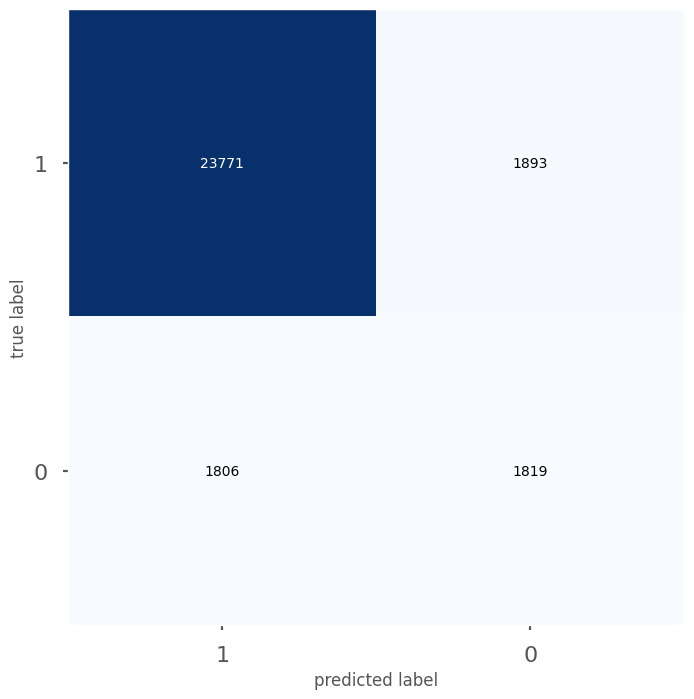

Adventure
accuracy: 0.8681416231349653 precision: 0.268210197710718 recall: 0.49567307692307694 f1: 0.34807562457798785


<Figure size 1280x880 with 0 Axes>

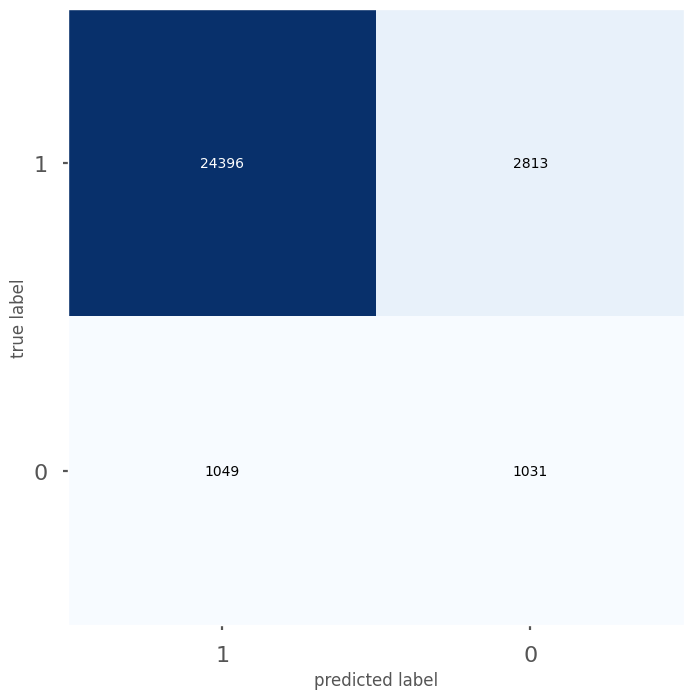

Animation
accuracy: 0.9624432380757281 precision: 0.69375 recall: 0.452445652173913 f1: 0.5476973684210527


<Figure size 1280x880 with 0 Axes>

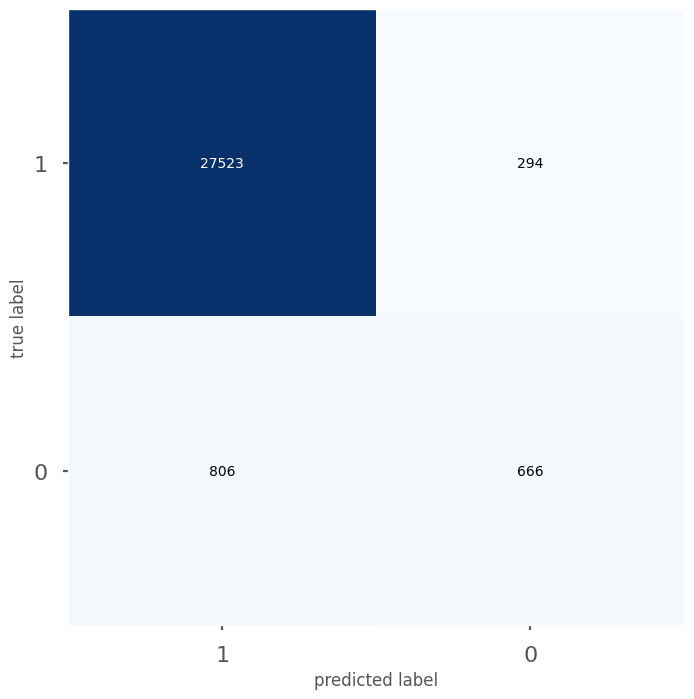

Biography
accuracy: 0.9336269589265594 precision: 0.20818291215403129 recall: 0.35523613963039014 f1: 0.2625189681335357


<Figure size 1280x880 with 0 Axes>

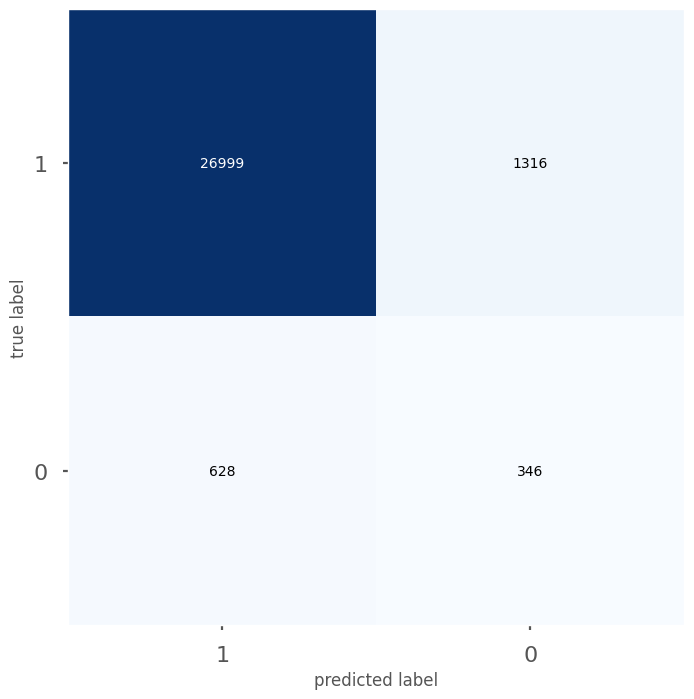

Comedy
accuracy: 0.7668066509611117 precision: 0.6074653822998194 recall: 0.5856065002901916 f1: 0.5963356973995271


<Figure size 1280x880 with 0 Axes>

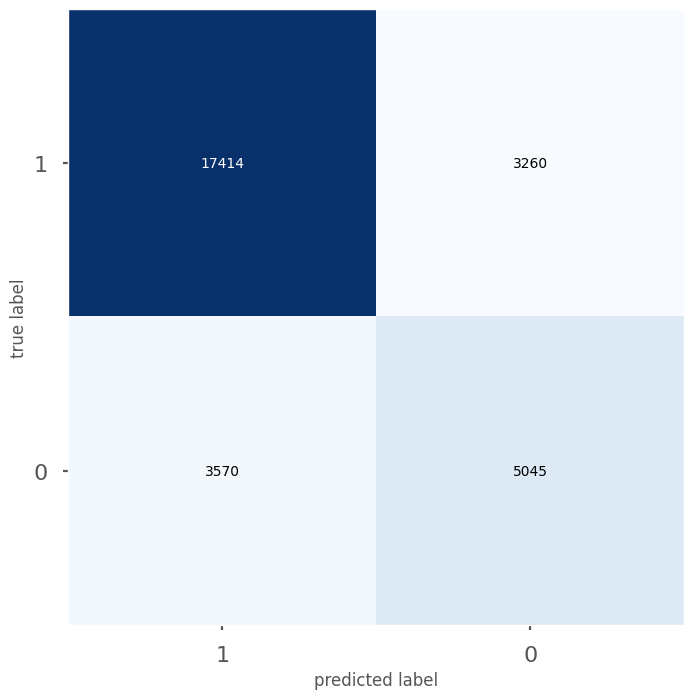

Crime
accuracy: 0.8805694970808153 precision: 0.44127611518915866 recall: 0.5071382219338092 f1: 0.47192028985507245


<Figure size 1280x880 with 0 Axes>

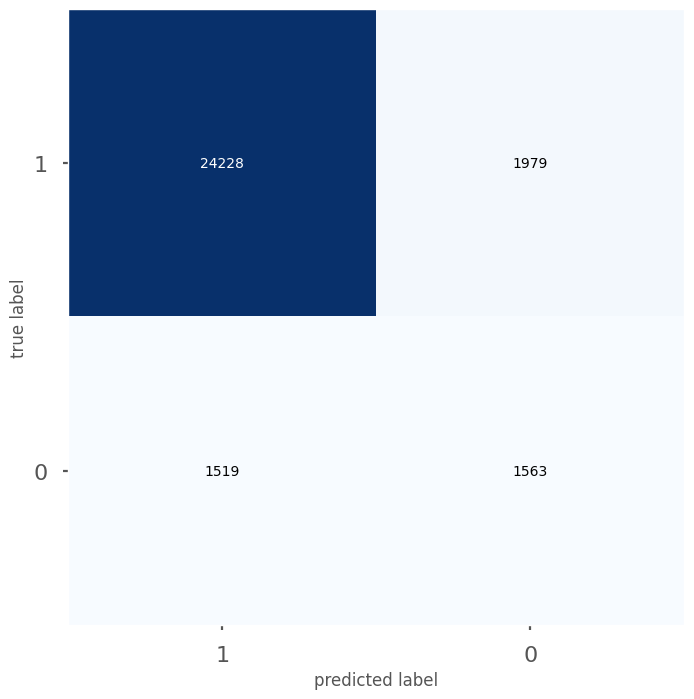

Documentary
accuracy: 0.933558673904879 precision: 0.7028804007514089 recall: 0.6924737816162863 f1: 0.6976382846488502


<Figure size 1280x880 with 0 Axes>

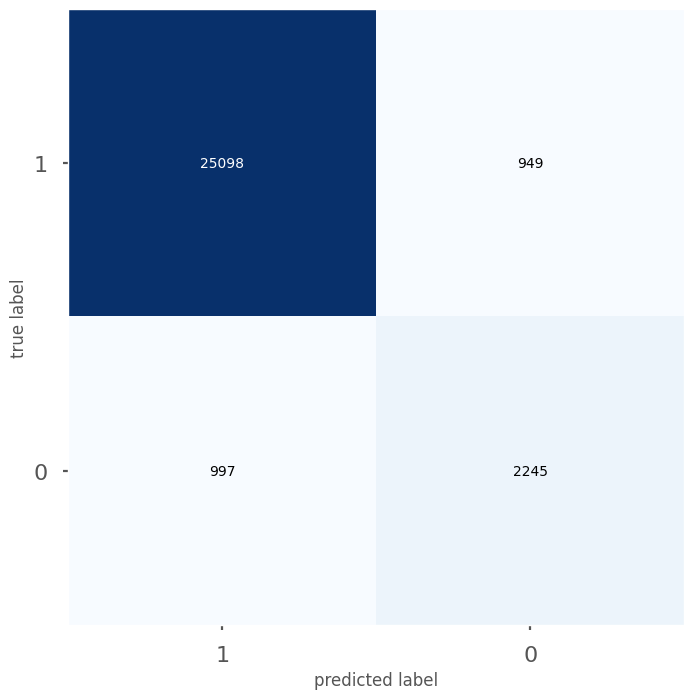

Drama
accuracy: 0.692546689883574 precision: 0.6348075087496023 recall: 0.753360519558979 f1: 0.6890216527955244


<Figure size 1280x880 with 0 Axes>

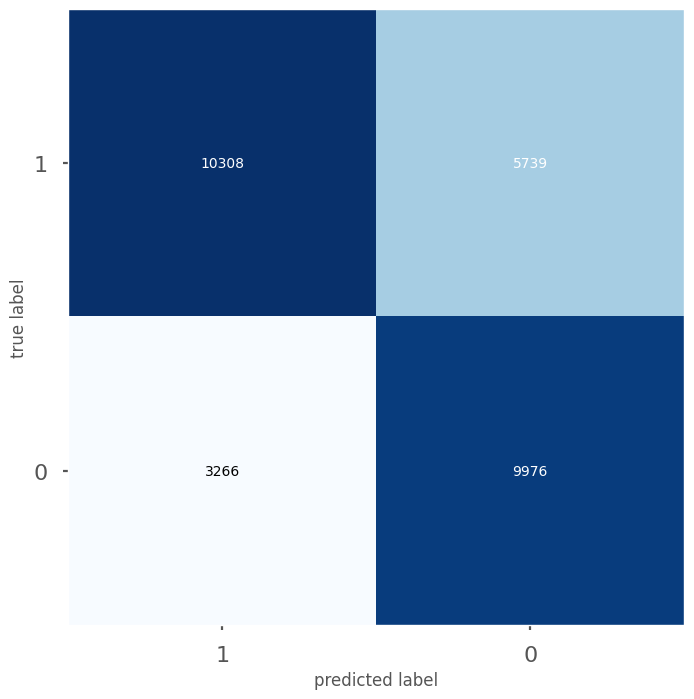

Family
accuracy: 0.9508689269008843 precision: 0.6399286987522281 recall: 0.224937343358396 f1: 0.33286972647195173


<Figure size 1280x880 with 0 Axes>

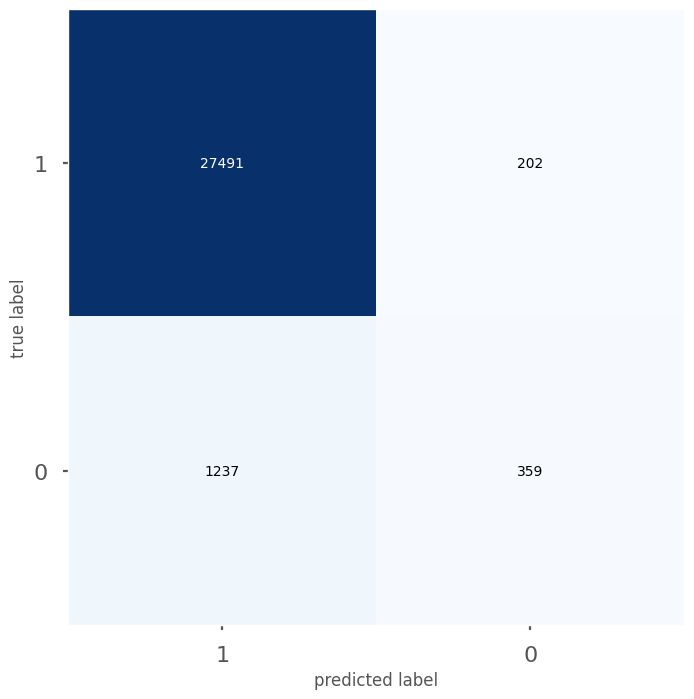

Fantasy
accuracy: 0.8614155484994367 precision: 0.14442546962673822 recall: 0.5174825174825175 f1: 0.22582490940301353


<Figure size 1280x880 with 0 Axes>

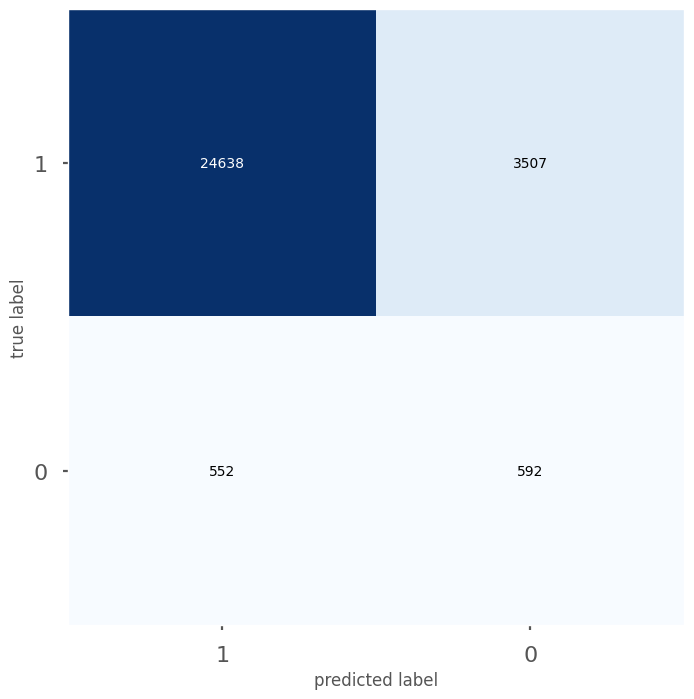

Film-Noir
accuracy: 0.9327051111338728 precision: 0.035246727089627394 recall: 0.56 f1: 0.06631927996210327


<Figure size 1280x880 with 0 Axes>

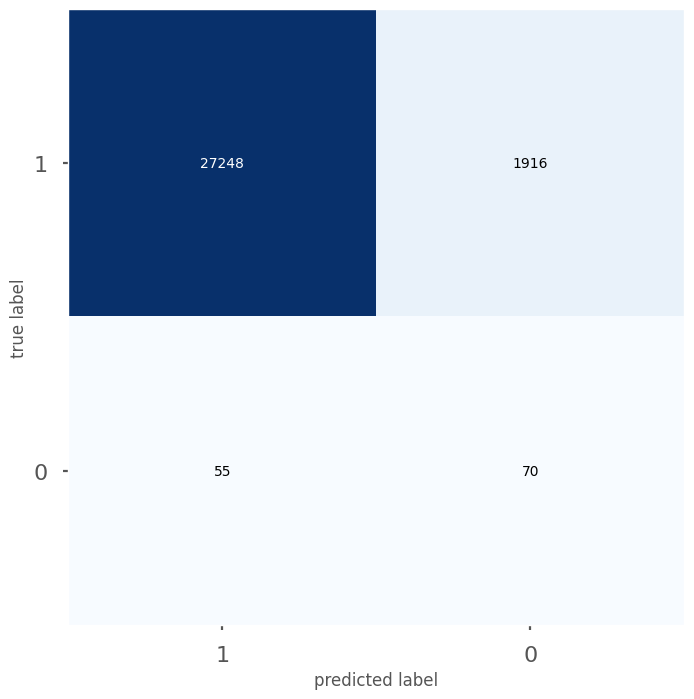

History
accuracy: 0.890743965311209 precision: 0.13430521091811415 recall: 0.5142517814726841 f1: 0.21298573536645352


<Figure size 1280x880 with 0 Axes>

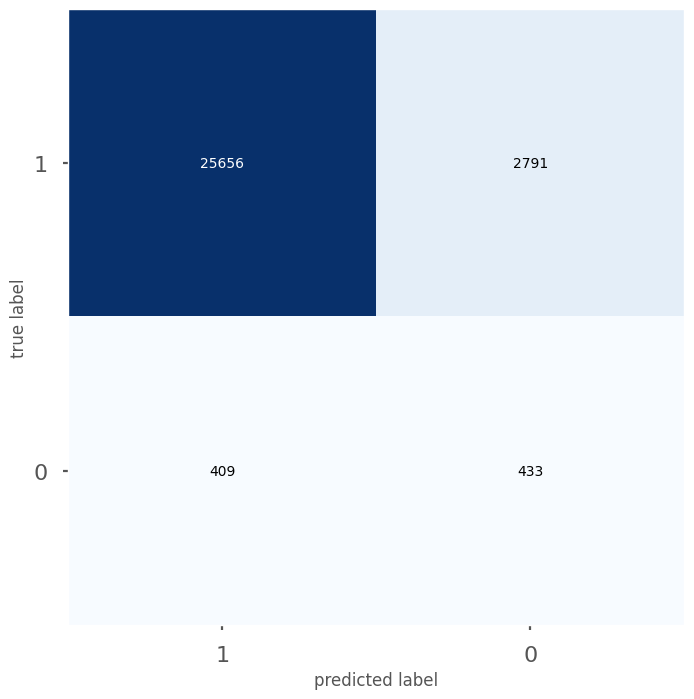

Horror
accuracy: 0.9211649424698692 precision: 0.621824686940966 recall: 0.5812709030100335 f1: 0.6008643042350909


<Figure size 1280x880 with 0 Axes>

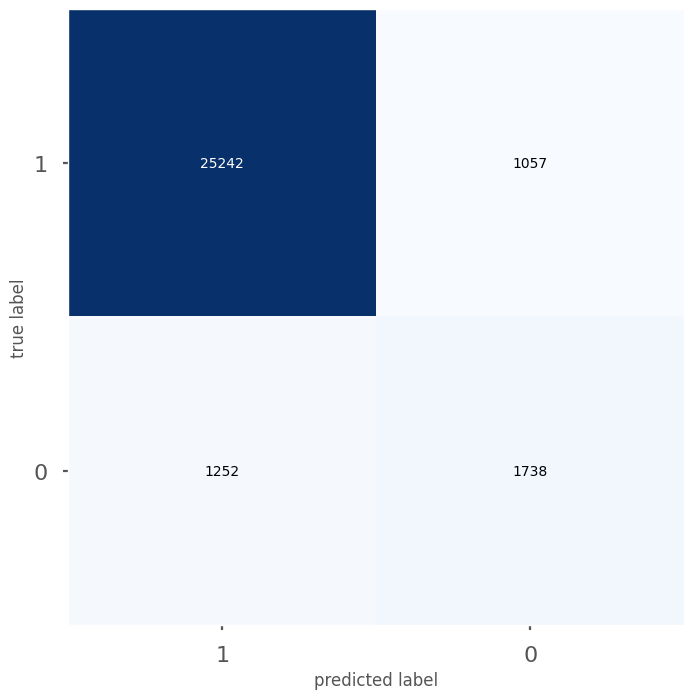

Music
accuracy: 0.9728225613711632 precision: 0.4671814671814672 recall: 0.31758530183727035 f1: 0.378125


<Figure size 1280x880 with 0 Axes>

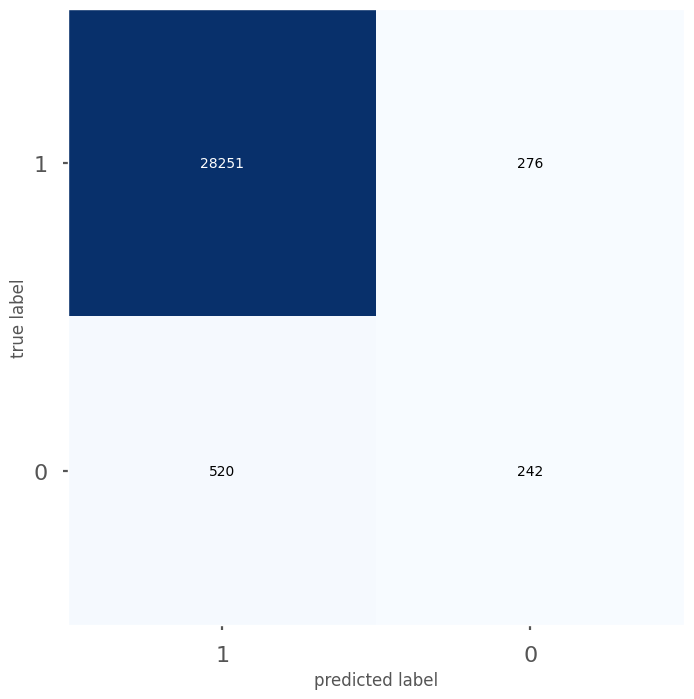

Musical
accuracy: 0.960223974871112 precision: 0.19 recall: 0.28171334431630973 f1: 0.22694094226940942


<Figure size 1280x880 with 0 Axes>

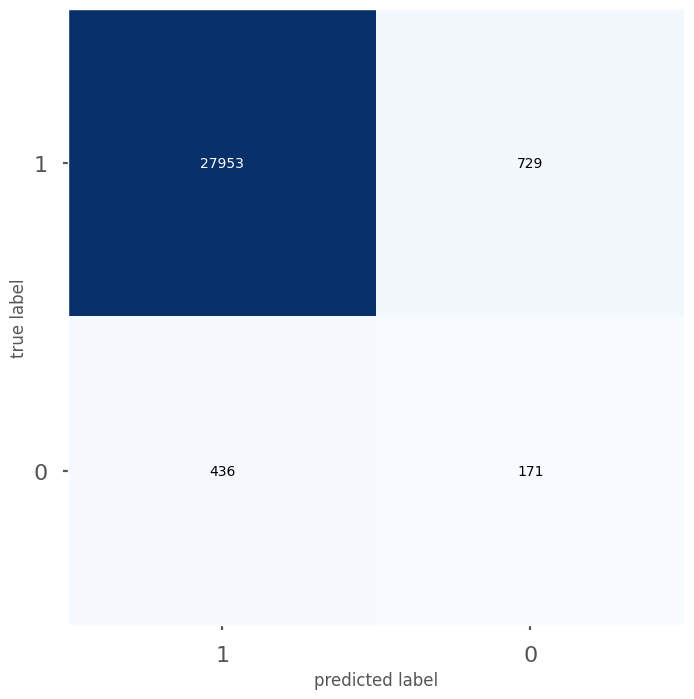

Mystery
accuracy: 0.8362183754993342 precision: 0.15863205603625877 recall: 0.519217801753203 f1: 0.2430172005680922


<Figure size 1280x880 with 0 Axes>

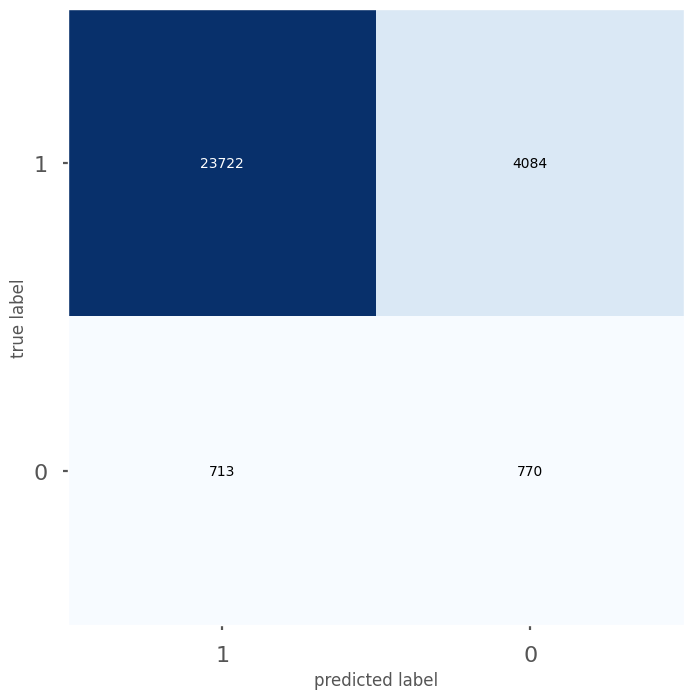

Romance
accuracy: 0.7902625559083615 precision: 0.3026953361599031 recall: 0.5651682216567713 f1: 0.3942411990927916


<Figure size 1280x880 with 0 Axes>

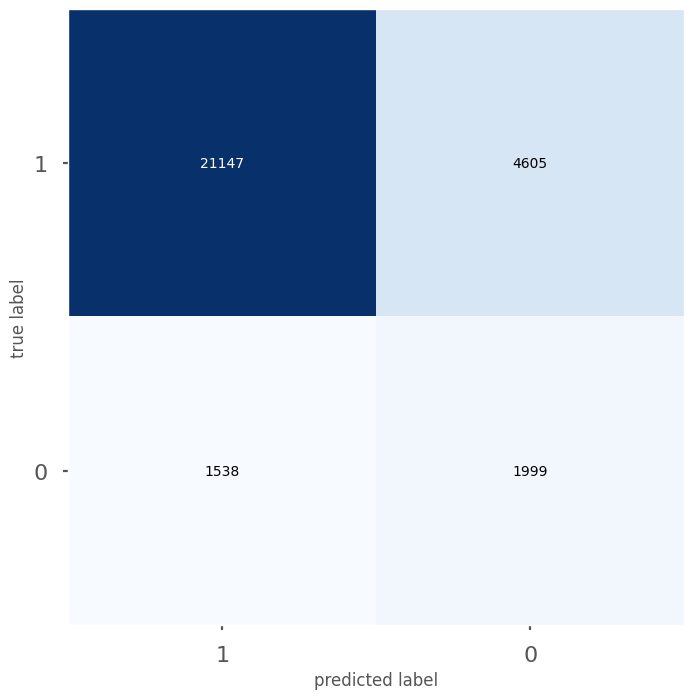

Sci-Fi
accuracy: 0.951244494520127 precision: 0.3431294678316124 recall: 0.4181994191674734 f1: 0.3769633507853403


<Figure size 1280x880 with 0 Axes>

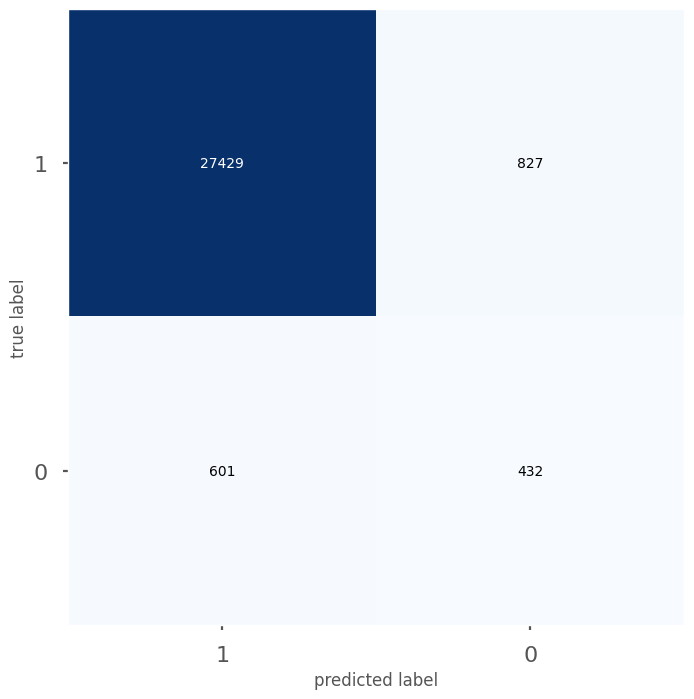

Short
accuracy: 0.8934412236675885 precision: 0.3825242718446602 recall: 0.3914944356120827 f1: 0.3869573757611472


<Figure size 1280x880 with 0 Axes>

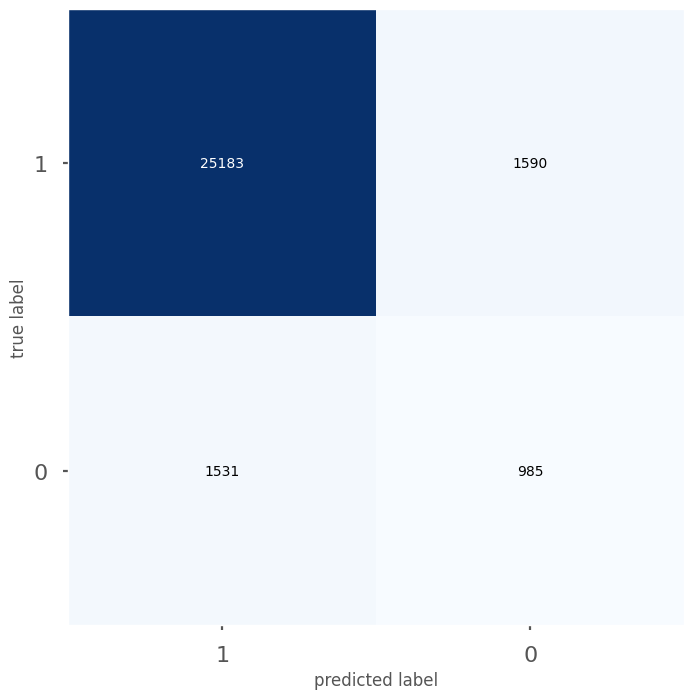

Sport
accuracy: 0.9798900611150944 precision: 0.3114406779661017 recall: 0.35766423357664234 f1: 0.33295583238958093


<Figure size 1280x880 with 0 Axes>

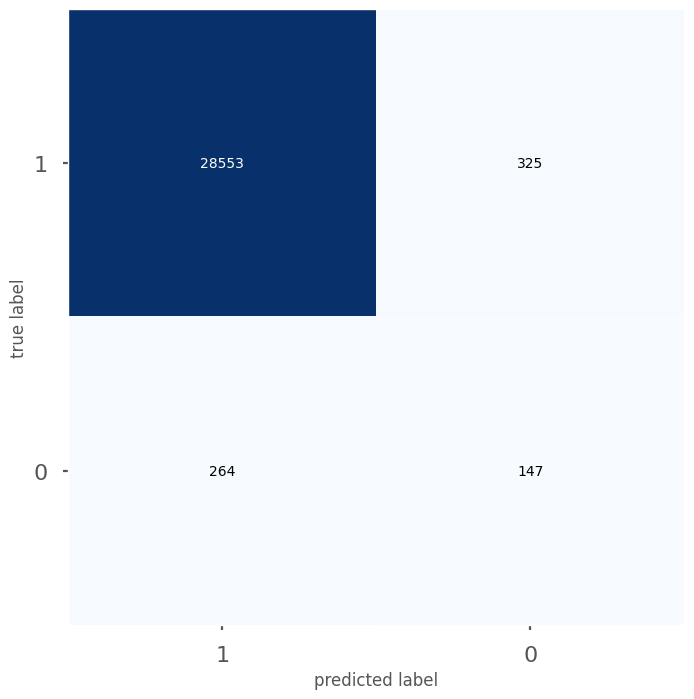

Thriller
accuracy: 0.7745228584110075 precision: 0.2761605035405193 recall: 0.6601880877742947 f1: 0.389423076923077


<Figure size 1280x880 with 0 Axes>

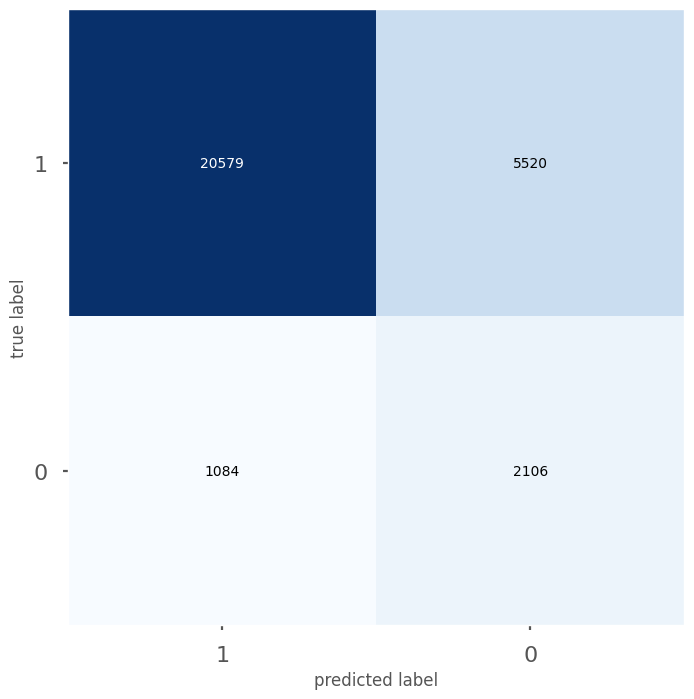

War
accuracy: 0.9660964867356345 precision: 0.29591836734693877 recall: 0.48903878583473864 f1: 0.36872218690400504


<Figure size 1280x880 with 0 Axes>

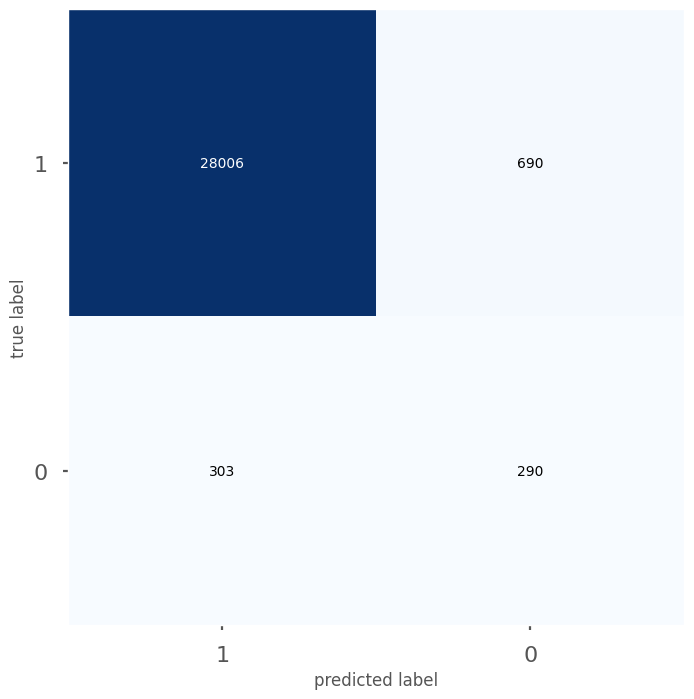

Western
accuracy: 0.9828604595581959 precision: 0.6535087719298246 recall: 0.6278089887640449 f1: 0.6404011461318052


<Figure size 1280x880 with 0 Axes>

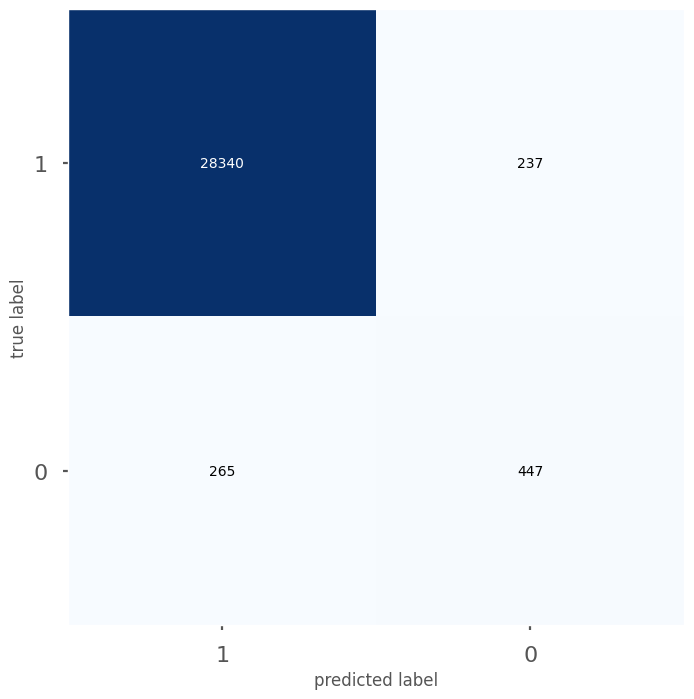

In [55]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

accuracy_per_class = []
precision_per_class = []
recall_per_class = []
f1_per_class = []
classes = list(mlb.classes_)
for i in range(labels.shape[0]):
    accuracy_per_class.append(accuracy_score(labels[i, :], preds[i, :]))
    precision_per_class.append(precision_score(labels[i, :], preds[i, :]))
    recall_per_class.append(recall_score(labels[i, :], preds[i, :]))
    f1_per_class.append(f1_score(labels[i, :], preds[i, :]))
    print(classes[i])
    print("accuracy:", accuracy_per_class[i], "precision:", precision_per_class[i],
          "recall:", recall_per_class[i], "f1:", f1_per_class[i])
    cm  = confusion_matrix(labels[i, :], preds[i, :])
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
    plt.xticks(range(2), ['1', '0'], fontsize=16)
    plt.yticks(range(2), ['1', '0'], fontsize=16)
    plt.show()

In [56]:
print("Acc:", np.mean(accuracy_per_class), "Precision:", np.mean(precision_per_class), "Recall:",
      np.mean(recall_per_class), "f1:", np.mean(f1_per_class))

Acc: 0.8946035534931498 Precision: 0.3914576764176481 Recall: 0.4943368765735385 f1: 0.40372444085619663


### Select N random films for prediction

In [331]:
test_data_original = pd.read_csv("/Users/annadosenko/Study/IndustrialML/2Lab/test_data.csv")

In [276]:
import random

films_indexes = random.sample(range(10000, len(test_data)), 10)
films_indexes

[18032, 20183, 27660, 23809, 18363, 16071, 12600, 20708, 21158, 11744]

In [311]:
films_indexes = [15496, 2800, 2851, 14, 7352, 12064, 9848, 12742, 9140]

15496 - Том и Джерри
2800 - Дэдпулл
2851 - Тайны перевала Дятлова
14 - Тёмный рыцарь
7352 - Мстители

In [332]:
titles, descriptions, paths, true_labels_list, true_labels_string = [], [], [], [], [] # arrays for random samples from test data
titles_original, description_original = [], []
for idx in films_indexes:
    sample = test_data.iloc[idx]
    titles.append(sample['origin_title'])
    descriptions.append(sample['description'])
    paths.append(sample['poster_paths'])
    true_labels_list.append(sample['genre_list'])
    true_labels_string.append(sample['genres'])
    titles_original.append(test_data_original.iloc[idx]['origin_title'])
    description_original.append(test_data_original.iloc[idx]['description'])

In [334]:
test_data_original.iloc[15496]

description     Spike the bulldog warns Tom to keep away from ...
id                                                          51098
genres                                 Adventure,Animation,Comedy
genre_list                   ['Adventure', 'Animation', 'Comedy']
poster_paths    /Users/annadosenko/Study/IndustrialML/2Lab/img...
origin_title                                       Tops with Pops
Name: 15496, dtype: object

In [333]:
titles_original

['Tops with Pops',
 'Deadpool 2',
 'The Dyatlov Pass Incident',
 'The Dark Knight Rises',
 'Avengers',
 'Ratatouille',
 "We're the Millers",
 'Saw',
 'Pride & Prejudice']

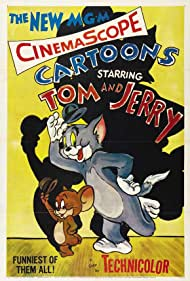

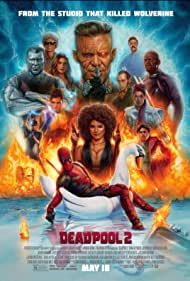

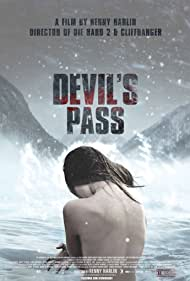

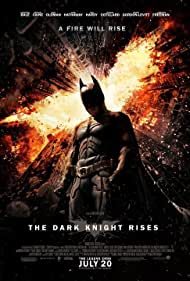

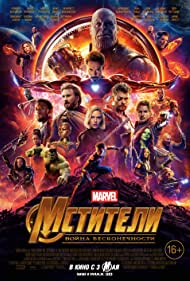

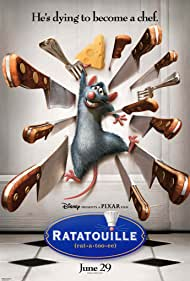

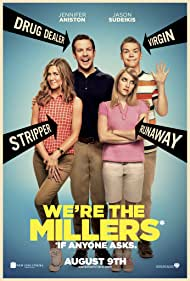

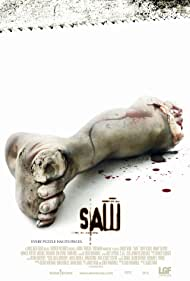

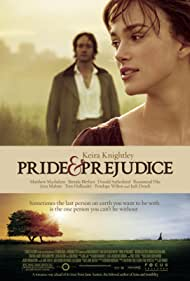

In [313]:
from IPython.display import Image, display

# let's check the poster images for each movie
for path in paths:
  display(Image(path, width=100))

In [314]:
descriptions

['spike bulldog warns tom keep away son tyke jerry realizes sticking close boy best way repel feline tormentor tom let mouse evade easily',
 'foulmouthed mutant mercenary wade wilson aka deadpool assembles team fellow mutant rogue protect young boy supernatural ability brutal timetraveling cyborg cable',
 'group student go location infamous dyatlov pas incident make documentary thing take turn worse secret happened revealed',
 'eight year joker reign anarchy batman help enigmatic selina kyle forced exile save gotham city brutal guerrilla terrorist bane',
 'avenger ally must willing sacrifice attempt defeat powerful thanos blitz devastation ruin put end universe',
 'rat cook make unusual alliance young kitchen worker famous paris restaurant',
 'veteran pot dealer creates fake family part plan move huge shipment weed u mexico',
 'two stranger awaken room recollection got soon discover theyre pawn deadly game perpetrated notorious serial killer',
 'spark fly spirited elizabeth bennet meet

In [315]:
# using the Tokenizer above, convert the listo f Movie Overview texts to an array of tokens, 
# and then pad with zero until max_length
input_description = tokenizer.texts_to_sequences(descriptions)
input_description = pad_sequences(input_description, maxlen=MAX_SEQUENCE_LENGTH_DESCRIPTION)
input_description

array([[    0,     0,     0, ...,   870,  5265,  3394],
       [    0,     0,     0, ..., 14501,  6198,  6877],
       [    0,     0,     0, ...,    71,   928,  1604],
       ...,
       [    0,     0,     0, ...,  6495,   125,   584],
       [    0,     0,     0, ...,   818,   409,    96],
       [    0,     0,     0, ...,  1104,  3243,  3049]], dtype=int32)

In [316]:
input_titles = tokenizer_titles.texts_to_sequences(titles)
input_titles = pad_sequences(input_titles, maxlen=MAX_SEQUENCE_LENGTH_TITLES)
input_titles

array([[   0,    0,    0, ...,    0,  495, 1100],
       [   0,    0,    0, ...,    0,    0, 7777],
       [   0,    0,    0, ...,    0,  914, 1337],
       ...,
       [   0,    0,    0, ...,    0,    0, 3541],
       [   0,    0,    0, ...,    0,    0, 1200],
       [   0,    0,    0, ...,    0, 1127, 4471]], dtype=int32)

In [317]:
input_description.shape

(9, 364)

Image preprocessing

In [318]:
import cv2

# function to resize poster images and then normalize the data to a value between 0~1
def resize_img(path):
  try:
    img = cv2.imread(path)
    img = cv2.resize(img, (75, 115))
    img = img.astype(np.float32)/255
    return img
  except Exception as e:
    print(str(e))
    return None

In [319]:
# convert the images to numpy arrays
imgs = [resize_img(path) for path in paths]
input_images = np.array(imgs)
print(input_images.shape)

(9, 115, 75, 3)


In [320]:
input_description_tensor = torch.tensor(input_description)
input_description_tensor


tensor([[    0,     0,     0,  ...,   870,  5265,  3394],
        [    0,     0,     0,  ..., 14501,  6198,  6877],
        [    0,     0,     0,  ...,    71,   928,  1604],
        ...,
        [    0,     0,     0,  ...,  6495,   125,   584],
        [    0,     0,     0,  ...,   818,   409,    96],
        [    0,     0,     0,  ...,  1104,  3243,  3049]], dtype=torch.int32)

In [321]:
input_titles_tensor = torch.tensor(input_titles)
input_titles

array([[   0,    0,    0, ...,    0,  495, 1100],
       [   0,    0,    0, ...,    0,    0, 7777],
       [   0,    0,    0, ...,    0,  914, 1337],
       ...,
       [   0,    0,    0, ...,    0,    0, 3541],
       [   0,    0,    0, ...,    0,    0, 1200],
       [   0,    0,    0, ...,    0, 1127, 4471]], dtype=int32)

In [322]:
input_images = np.reshape(input_images, (input_images.shape[0], 3, 75, 115))

In [323]:
input_images_tensor = torch.tensor(input_images)

Predict genres

In [325]:
out_genres = model(input_description_tensor, input_titles_tensor, input_images_tensor)
out_genres

tensor([[1.7691e-03, 7.9714e-02, 9.9783e-01, 3.1889e-10, 9.8088e-01, 9.6516e-05,
         6.4810e-08, 2.3226e-04, 9.6250e-01, 1.9072e-03, 4.1653e-17, 1.2448e-07,
         3.9436e-07, 6.8439e-04, 1.3844e-03, 7.4534e-07, 1.7620e-05, 2.5679e-06,
         1.4261e-02, 8.2636e-07, 5.5243e-09, 8.1239e-08, 3.0743e-06],
        [8.5122e-01, 6.3942e-01, 1.5571e-01, 3.9048e-04, 1.7981e-01, 1.0330e-02,
         9.8424e-04, 9.9435e-02, 3.0282e-02, 1.5352e-01, 2.7851e-06, 6.6850e-03,
         2.1099e-02, 3.9159e-04, 7.2295e-03, 1.0640e-02, 1.2968e-02, 3.3479e-01,
         9.9062e-03, 4.8497e-04, 1.9587e-02, 6.6694e-03, 8.9766e-04],
        [3.0157e-02, 8.9405e-03, 4.1033e-03, 1.0701e-03, 5.2966e-02, 6.0259e-02,
         5.0895e-03, 4.4762e-01, 2.3213e-03, 6.6547e-02, 6.1315e-04, 8.0090e-04,
         7.0811e-01, 2.7966e-03, 2.1299e-03, 3.2274e-01, 3.5394e-02, 6.1301e-02,
         6.2695e-02, 1.2386e-06, 5.5850e-01, 6.6311e-05, 8.7201e-04],
        [8.9628e-01, 5.4656e-01, 3.3486e-02, 5.5359e-03, 4.63

In [326]:
true_labels_list

[['Adventure', 'Animation', 'Comedy'],
 ['Action', 'Adventure', 'Comedy'],
 ['Horror', 'Mystery', 'Thriller'],
 ['Action', 'Crime', 'Drama'],
 ['Action', 'Adventure', 'Sci-Fi'],
 ['Adventure', 'Animation', 'Comedy'],
 ['Comedy', 'Crime'],
 ['Horror', 'Mystery', 'Thriller'],
 ['Drama', 'Romance']]

In [327]:
import operator

def get_labels(pred):
    labels=[]
    indexed = list(enumerate(pred))
    top_3 = sorted(indexed, key=operator.itemgetter(1))[-3:]
    label_idxs = list(reversed([i for i, v in top_3]))
    for ind in label_idxs:
        labels.append(mlb.classes_[ind])
    return labels

In [328]:
out_genres.shape

torch.Size([9, 23])

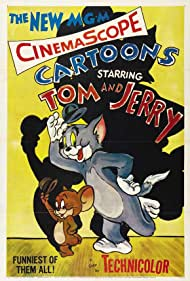

Description:  Spike the bulldog warns Tom to keep away from his son, Tyke. Jerry realizes that sticking close to the boy is the best way to repel his feline tormentor, but Tom is not about to let the mouse evade him so easily.
True label genres: ['Adventure', 'Animation', 'Comedy']
Tops with Pops:  ['Animation', 'Comedy', 'Family']


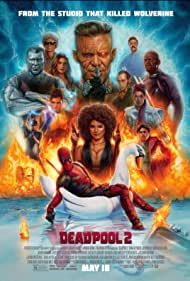

Description:  Foul-mouthed mutant mercenary Wade Wilson (a.k.a. Deadpool) assembles a team of fellow mutant rogues to protect a young boy with supernatural abilities from the brutal, time-traveling cyborg Cable.
True label genres: ['Action', 'Adventure', 'Comedy']
Deadpool 2:  ['Action', 'Adventure', 'Sci-Fi']


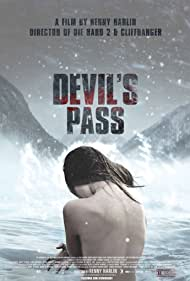

Description:  A group of students go to the location of the infamous Dyatlov pass incident to make a documentary, but things take a turn for the worse as the secret of what happened there is revealed.
True label genres: ['Horror', 'Mystery', 'Thriller']
The Dyatlov Pass Incident:  ['Horror', 'Thriller', 'Drama']


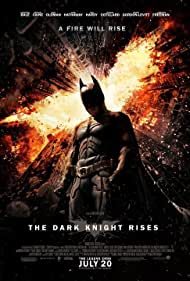

Description:  Eight years after the Joker's reign of anarchy, Batman, with the help of the enigmatic Selina Kyle, is forced from his exile to save Gotham City from the brutal guerrilla terrorist Bane.
True label genres: ['Action', 'Crime', 'Drama']
The Dark Knight Rises:  ['Action', 'Adventure', 'Drama']


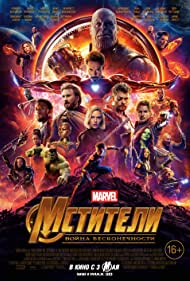

Description:  The Avengers and their allies must be willing to sacrifice all in an attempt to defeat the powerful Thanos before his blitz of devastation and ruin puts an end to the universe.
True label genres: ['Action', 'Adventure', 'Sci-Fi']
Avengers:  ['Action', 'Adventure', 'Drama']


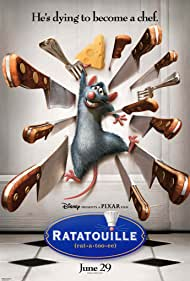

Description:  A rat who can cook makes an unusual alliance with a young kitchen worker at a famous Paris restaurant.
True label genres: ['Adventure', 'Animation', 'Comedy']
Ratatouille:  ['Comedy', 'Fantasy', 'Drama']


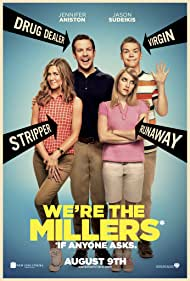

Description:  A veteran pot dealer creates a fake family as part of his plan to move a huge shipment of weed into the U.S. from Mexico.
True label genres: ['Comedy', 'Crime']
We're the Millers:  ['Drama', 'Crime', 'Action']


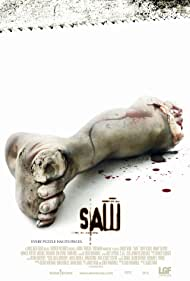

Description:  Two strangers awaken in a room with no recollection of how they got there, and soon discover they're pawns in a deadly game perpetrated by a notorious serial killer.
True label genres: ['Horror', 'Mystery', 'Thriller']
Saw:  ['Action', 'Thriller', 'Drama']


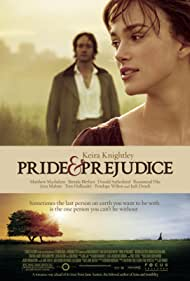

Description:  Sparks fly when spirited Elizabeth Bennet meets single, rich, and proud Mr. Darcy. But Mr. Darcy reluctantly finds himself falling in love with a woman beneath his class. Can each overcome their own pride and prejudice?
True label genres: ['Drama', 'Romance']
Pride & Prejudice:  ['Comedy', 'Drama', 'Romance']


In [335]:
for idx, pred in enumerate(out_genres):
    display(Image(paths[idx], width=100))
    print("Description: ", description_original[idx])
    print(f"True label genres: {true_labels_list[idx]}")
    print(titles_original[idx]+": ", get_labels(pred)) # get three genres with the biggest probability, out of 18 genres --> different from the Training IPYNB (we used the 0.5 threshold over there)